# Title: BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding

### Group Member Names : Dev Patel , Niki Patel 



### INTRODUCTION:
*********************************************************************************************************************
#### AIM : 
Assess the efficiency of the approach outlined in the paper "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" through the examination of accuracy as a metric of performance.
*********************************************************************************************************************
#### Github Repo: 
https://github.com/VikasSingh-DS/Movies-Reviews-Bert-Sentiment-Flask-API
*********************************************************************************************************************
#### DESCRIPTION OF PAPER:
The study presents BERT, a novel language comprehension model known as Bidirectional Encoder Representations from Transformers. BERT's distinctiveness arises from its bidirectional training strategy, allowing it to understand sentence context from both ends. By undergoing pre-training using extensive text datasets, BERT gains sophisticated word representations, resulting in notable performance across various tasks like sentiment analysis and question answering. Its accomplishments redefine the forefront of natural language processing and understanding.
*********************************************************************************************************************
#### PROBLEM STATEMENT :
* Attempt to achieve analogous results as reported in the paper by implementing the same strategies on the IMDb dataset.
* Datasets used here :
1) IMDB_review - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie reviews
2) Finance_news - https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

* Finding accuracy using BERT and LinearSVM on above mentioned datasets and concluding the result.
*********************************************************************************************************************
#### CONTEXT OF THE PROBLEM:

* Traditional language models, like RNNs and early transformer models, operated in a unidirectional manner.
These models processed text from left to right or right to left, focusing on one direction only
* This unidirectional approach posed challenges in capturing comprehensive contextual relationships between words. 
Models could not fully comprehend intricate linguistic nuances and word interactions.* Nuanced language elements, such as idiomatic expressions, were difficult for these models to interpret accurately.
* 
Complex sentence structures and dependencies were often not well understood due to the one-sided context.
.
*********************************************************************************************************************
#### SOLUTION:
* BERT (Bidirectional Encoder Representations from Transformers) was introduced to address these limitations. It utilized a bidirectional training approach, considering both left and right context for each word.
* BERT's bidirectional training allowed it to capture intricate word relationships, idiomatic expressions, and contextual nuances effectively.:
* 


# Background
*********************************************************************************************************************

### Unsupervised Feature-based Approaches

|Reference|Explanation|Weakness|
|------|------|------|
 Brown et al., 1992; Ando and Zhang, 2005; Blitzer et al., 2006 |  Learning representations of words using non-neural methods. |Limited in capturing complex contextual information.
 Mikolov et al., 2013; Pennington et al., 2014 |  Learning representations using neural methods, including word embeddings.|  Initial embeddings might not capture deep contextual understanding.
 Peters et al., 2017, 2018a |  ELMo introduces contextual features from left-to-right and right-to-left language models.| Feature-based, not deeply bidirectional.

### Unsupervised Fine-tuning Approaches

|Reference|Explanation|Weakness|
|------|------|------|
Dai and Le, 2015; Howard and Ruder, 2018; Radford et al., 2018 | Pre-training contextual token representations and fine-tuning for downstream tasks. |Dependency on pre-training quality, model size, and availability of labeled data.

### Transfer Learning from Supervised Data

|Reference|Explanation|Weakness|
|------|------|------|
Conneau et al., 2017; McCann et al., 2017 | Effective transfer from tasks with large supervised datasets. |Success depends on task similarity and data availability.
*********************************************************************************************************************






# Methodology
### Basic Details of BERT :
- BERT employs a transformer-based neural network architecture designed for understanding language.
- Unlike traditional models, BERT captures context from both preceding and succeeding words in a sentence.
- BERT is pre-trained using two objectives: Masked Language Model (MLM) and Next Sentence Prediction (NSP).
- After pre-training, BERT fine-tunes for tasks by incorporating task-specific layers and parameter adjustments. It leverages special tokens([CLS] and [SEP]) for sequence context and shares knowledge by reusing pre-trained parameters across diverse tasks.
- BERT's adaptability spans text and other data tasks, while its ensemble approach combines fine-tuned model predictions via majority voting, bolstering overall performance.

# Implement paper code :
*********************************************************************************************************************
## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import os
import transformers
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import logging
logging.getLogger().setLevel(logging.NOTSET)

# Configuration

In [2]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 3
BERT_PATH = "../input/bert-base-uncased"
MODEL_PATH = "model.bin"
TRAINING_FILE = "../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

# Data Exploration

In [3]:
"""Reading dataset"""
df = pd.read_csv(TRAINING_FILE)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
"Data Dresription"
print('Shape of the dataset', df.shape)
print('Missing values')
print(df.isnull().sum())

Shape of the dataset (50000, 2)
Missing values
review       0
sentiment    0
dtype: int64


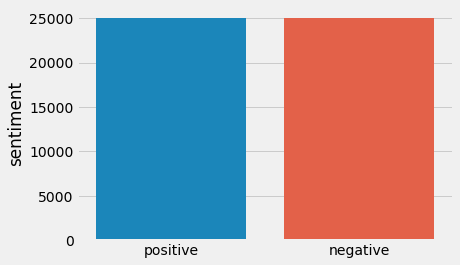

In [5]:
"""Distribution of target variable"""
temp = df["sentiment"].value_counts()
sns.barplot(temp.index, temp)
plt.show()

Target distribution is perfectly balanced.

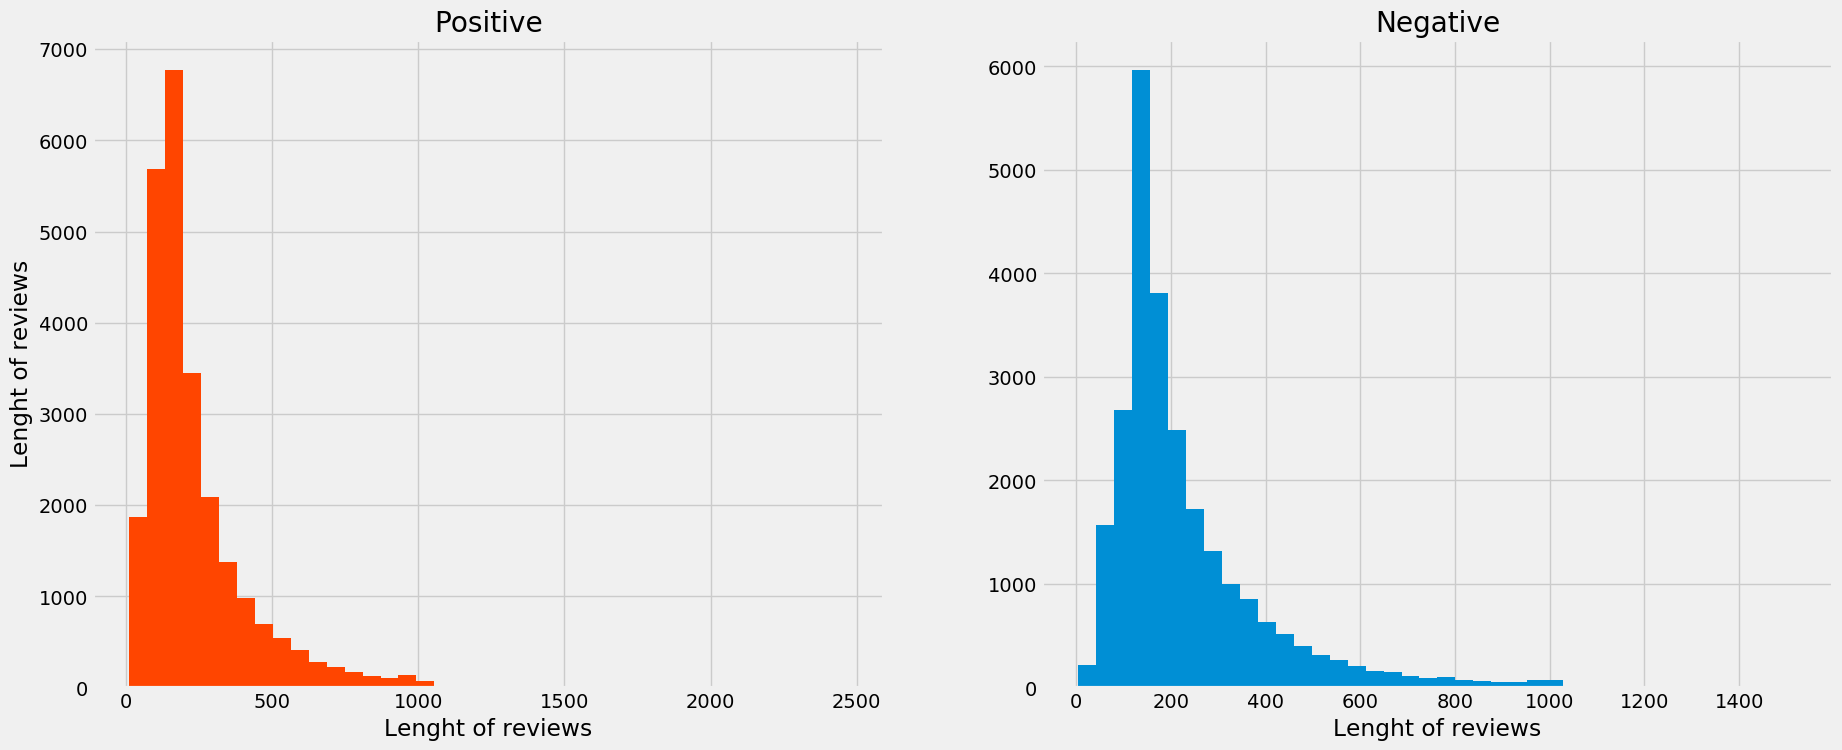

In [6]:
'''Plot sentence lenght'''
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(20, 8), dpi=100)
num=df[df["sentiment"]=='positive']['review'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 40,color='orangered')
ax1.set_title('Positive')
ax1.set_xlabel('Lenght of reviews')
num=df[df["sentiment"]=='negative']['review'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 40)
ax2.set_title('Negative')
ax2.set_xlabel('Lenght of reviews')
ax1.set_ylabel('Lenght of reviews')
plt.show()

# Build and Train the Model

In [7]:
class BERTDataset:
    '''
    We are required to give it a number of pieces of information which seem redundant, 
    or like they could easily be inferred from the data without us explicity providing it.
    This class prepare the dataset or input format to BERT modeling.
    '''
    def __init__(self, review, target):
        self.review = review
        self.target = target
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        review = " ".join(review.split())

        inputs = self.tokenizer.encode_plus(
            review,                         # sentence to encode
            None,
            add_special_tokens=True,        # add '[CLS]' and '[SEP]'
            max_length=self.max_len,        # pad & truncate all sentences.
            pad_to_max_length=True
        )
        
        # Map the tokens to thier word ids, mask and attention_mask
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        # Return pytorch tensors
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.float)
        }

In [8]:
class BERTBaseUncased(nn.Module):
    '''
    we'll be using BERT Model. This class we feed the bert input data, the entire pre-trained
    BERT model and the additional untrained classification layer is trained on our specific task.
    '''
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_PATH)
        self.bert_drop = nn.Dropout(0.3)    # define the dropout
        self.out = nn.Linear(768, 1)        # fully connected linear layer

    def forward(self, ids, mask, token_type_ids):
        # Perform a forward pass. Feeding the inputs in the bert model
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)     # performing dropout on  output vector
        output = self.out(bo)       # performing fully connected linear layer on output vector
        return output 


In [9]:
total_train_loss = 0
total_eval_loss = 0

# define the binary_cross_entropy loss function
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

# define the trainging function
def train_fn(data_loader, model, optimizer, device, scheduler):
    global total_train_loss 
    
    # Set the model to training mode
    model.train()
    # trange is a tqdm wrapper around the normal python range
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
         # Unpack training batch from our dataloader.
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]
        
        # copy each tensor to the GPU
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        
        # clear any previously calculated gradients
        optimizer.zero_grad()
        # outputs prior to activation.
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)    # Perform a loss funtion
        total_train_loss += loss.item()     # Accumulate the training loss
        loss.backward()                     # Perform a backward pass to calculate the gradients
        optimizer.step()                    # Update parameters
        scheduler.step()                    # Update the learning rate
        
        
        
        
# define the validation function
def eval_fn(data_loader, model, device):
    global total_eval_loss
    model.eval()            # Set the model to training mode
    fin_targets = []        # target variable
    fin_outputs = []        # ouput variable
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
        # trange is a tqdm wrapper around the normal python range
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            # Unpack validation batch from our dataloader.
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]
            
            # copy each tensor to the GPU
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            
            # outputs prior to activation.
            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            
            loss = loss_fn(outputs, targets)        # Perform a loss funtion
            total_eval_loss += loss.item()          # Accumulate the validation loss.
            
            # Move target and output to CPU
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [10]:
device = torch.device("cuda")     # define the device
model = BERTBaseUncased()         # define the model
model.to(device)                  # copy the model to the gpu

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [11]:
 training_stats = []
    
# running script funtion
def run():
    print('==== Training And Validation ==== ')
     # Load the dataset into a pandas dataframe.
    dfx = pd.read_csv(TRAINING_FILE).fillna("none")
    dfx.sentiment = dfx.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    
    # split up our traing set to use 90% for training and 10% for validation
    df_train, df_valid = model_selection.train_test_split(
        dfx, test_size=0.1, random_state=42, stratify=dfx.sentiment.values
    )
    
    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)
    
    # pass the sentence and target from training dataset into class
    train_dataset = BERTDataset(
        review=df_train.review.values, target=df_train.sentiment.values
    )
    
    # Combine the training inputs into a TensorDataset.
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4
    )
    
    # pass the sentence and target from training dataset into class
    valid_dataset = BERTDataset(
        review=df_valid.review.values, target=df_valid.sentiment.values
    )
    
    # Combine the training inputs into a TensorDataset.
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=4
    )

    
    # Prepare optimizer and schedule (linear warmup and decay)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n,p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    
    # Create the numer of training steps, optimizer and scheduler
    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )
    
    # running the loop for every epochs
    # Tracking variables 
    best_accuracy = 0
    for epoch in range(EPOCHS):
        
        # passing training and validation funtion
        train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        
        # Calculate the average train loss
        avg_train_loss = total_train_loss / len(train_data_loader)
        
        # Calculate the average valid loss
        avg_val_loss = total_eval_loss / len(valid_data_loader)
        
        # Calculate the validation accuracy for test sentences
        eval_accuracy = metrics.accuracy_score(targets, outputs)
        
        # Report the final accuracy for this validation run.
        print(f"Validation Accuracy Score {eval_accuracy}")
        
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
            }
        )
        
        # saving the model
        if eval_accuracy > best_accuracy:
            torch.save(model.state_dict(), MODEL_PATH)
            best_accuracy = eval_accuracy


if __name__ == "__main__":
    run()

==== Training And Validation ==== 


100%|██████████| 1250/1250 [01:38<00:00, 12.73it/s]


Validation Accuracy Score 0.9402


100%|██████████| 1250/1250 [01:37<00:00, 12.88it/s]


Validation Accuracy Score 0.9434


100%|██████████| 1250/1250 [01:36<00:00, 12.94it/s]


Validation Accuracy Score 0.9514


*********************************************************************************************************************
### Contribution  Code :
* Applied same methodology of BERT on finance data set and compared that output with Linear Support Vector Classifier.
* Link of code for above : (https://github.com/nikkipatel19/finalproject/blob/main/sentiment-analysis-using-bert.ipynb)
* Applied Linear Support Vector Classifier on IMDB_dataset as well as shown in (https://github.com/nikkipatel19/finalproject/blob/main/IMDB_Movie_Review.ipynb) which gave conclusion that bert gives rsult with more accuracy as compared to other model.

### Results :
*******************************************************************************************************************************
- After applying both methodology on two different dataset, BERT gave 95% accuracy while other gave 85% on IMDB_dataset.
- Same for Finance_dataset, BERT outplayed other model where it gave 80% accuracy where other models (RandomForest, XGBoost) gave less than 70% accuracy.

#### Observations :
*******************************************************************************************************************************
* After applying this technique on both the datasets, it is crstal clear that BERT can be helpfull significantly for getting output more accurately.


### Conclusion and Future Direction :
*******************************************************************************************************************************
#### Learnings : 
While completing this project I learned about using Github and how to clone github repositories as well. Apart from this, I also learned applying prebuild models into code that decreases work need to get desired output. 

* Learned bout building a model and class through github code that gave me in-depth idea on making custom model.
* Used transformers library to get pre-build model (Bert-base-uncased) and implemented it in the code.
* Learnt how BERT works by reading data from both side and how it learns from preceding and succeeding words in a sentence.
* Applying RandomForest and XGBoost classifier took almost 5+hours where using BERT decreased that time drasticslly
*******************************************************************************************************************************
#### Results Discussion :

The main goal of comparing accuracy of BERT on various dataset was achieved where we applied various classifiers on IMDB_Dataset and Finance_dataset.

- In both the datasets, the most satisfying and acceptable output was given by BERT since it took less time to give better result with greater accuracy.
*******************************************************************************************************************************
#### Limitations :
#### Limitation of BERT :
* Demands significant memory and computation resources.
* 
Limited in capturing context beyond a fixed window.* 
Lacks true comprehension and common sense reasoning* .
Transferability might not be optimal for all task* s.
Vulnerable to context changes and adversarial attac* ks.
Handles out-of-vocabulary words with subword units.

**************************************************************************************************************************
#### Future Extension :

* Develop models that can capture even longer-range dependencies and more dynamic context in text, addressing BERT's fixed window limitation.
* Extend models to effectively integrate and understand both text and visual data, enabling deeper comprehension of content that involves both modalities.
* Enhance models to provide more transparent explanations for their predictions, addressing the "black-box" nature of deep learning models.on :
